In [1]:
### USING ALL DIFF EXP (1335)-(Lasso and RFE 100 overlap feature elimination)+PCA 10+SMOTE+5 REPEATS = 17 FEATURES

'''
TODO: Find the best n transcripts by April 29th
    - do feature selection with: 1) Lasso 2) RFE 3) Boruta 4) RF 5) Any Combo
    - run LassoLR, RF, Pamr, XgBoost, Boruta over top 500 diff expressed genes
    - store running array of sorted descending RF variable importance if AUC > 0.7 - done!
    - store running array of sorted descending LassoLR coefficient size if AUC > 0.7
    - store running array of sorted descending XgBoost coefficient size if AUC > 0.7
    - store running array of sorted descending Boruta coefficient size if AUC > 0.7
    - find the intersection of the top n genes that gives x important genes - meh - not useful even if we do it, only used for confirming RF importance
        vary n until you get at least x important genes:
        for instance, look at the top n=200 most important features from each list
        and find the intersection set, which will be of size x=50
    OR 
        just use RF feature importance only
            - first try finding top 50 genes out of 50 diff expressed (as a control) - done (captured 100% information)
            - then try finding top 50 genes out of 500 diff expressed - 
            - then try finding top 50 genes out of all diff expressed
            - then try finding top 50 genes out of all expressed - meh (noise will be too high so we expect poor results)
    - rerun the best model on ALL the data with only the top x genes (should be super high variance but whatever)

TODO Figures:

1) Top 50 best overlapping forward pass -> add PFS and OS of class I vs class II in the test set
2) Top 50 best overlapping -> retrain on the full dataset with the best params and SAVE
3) SAVED Top 50 overlapping -> test on the new test dataset with survival (unfortunately validation set only had one Grade I tumor)

Summary slides of methods for audience
Present the results
External validation
Kaplan-Meier Curves on original dataset

'''
# TODO: Use more data

'\nTODO: Find the best n transcripts by April 29th\n    - do feature selection with: 1) Lasso 2) RFE 3) Boruta 4) RF 5) Any Combo\n    - run LassoLR, RF, Pamr, XgBoost, Boruta over top 500 diff expressed genes\n    - store running array of sorted descending RF variable importance if AUC > 0.7 - done!\n    - store running array of sorted descending LassoLR coefficient size if AUC > 0.7\n    - store running array of sorted descending XgBoost coefficient size if AUC > 0.7\n    - store running array of sorted descending Boruta coefficient size if AUC > 0.7\n    - find the intersection of the top n genes that gives x important genes - meh - not useful even if we do it, only used for confirming RF importance\n        vary n until you get at least x important genes:\n        for instance, look at the top n=200 most important features from each list\n        and find the intersection set, which will be of size x=50\n    OR \n        just use RF feature importance only\n            - first try 

In [2]:
# TODO: Revisit normalizing transcripts based on tissue type
# DONE?: Generate gene score assay (probability of a grade from logistic regression, weights from RF)
# DONE?: exclude M1
# DONE: Exclude G4 and Gx
# DONE: try with differentially expressed genes only - doesn't help improve results

# three_class = True; two_class = False # (Grade I, Grade II, Grade III/IV)
two_class = True; three_class = False #(Grade I/II, Grade III/IV)

# Toggle to use_differentially_expressed_genes
use_differentially_expressed_genes=True; first_n_diff_exp_genes = None # Use all differentially expressed genes
# use_differentially_expressed_genes=True; first_n_diff_exp_genes = 500 # Use top 500 differentially expressed genes
# use_differentially_expressed_genes=False # use all 19904 genes

# Toggle to use various feature reduction methods (comment out/in as many as needed)
use_lasso=True
# use_lasso=False
use_rfe=True; number_of_rfe_genes_to_keep = 100
# use_rfe=False

# Toggle to use PCA to reduce dimensionality of data before passing into the algorithm
use_PCA=True; number_of_PCA_components = 10 # number_of_PCA_components must be less than first_n_diff_exp_genes
# use_PCA=False

# Decide the number of repeats to run the CV
# num_repeats = 50
num_repeats = 5

# Decide whether to override the training dataset to only use the top 50 most important features out of 500 differentially expressed genes, as chosen by RF
use_top_50_most_important_out_of_500 = False; use_top_100_most_important_out_of_500 = False
# use_top_50_most_important_out_of_500 = True; use_top_100_most_important_out_of_500 = False
# use_top_100_most_important_out_of_500 = True; use_top_50_most_important_out_of_500 = False



In [3]:
"""
Chat GPT-4 Initial Prompt
Please write code according to the methods described below:

l2-regularized multinomial Logistic Regression (LR) on the normalized and transformed data using 5-fold nested cross validation - more specifically: Logistic regression with an l2 penalty, trained via stochastic gradient descent. The logistic regression model is a single layer neural network with a softmax activation on the output. The hyperparameter optimized was the l2 penalty, logarithmically spaced between 10−6 and 103 in ten steps. The model was implemented in pytorch [56]. 

Also, use these Logistic Regression Hyperparameters.
• Weights were initialized randomly according to the standard (Xavier) Glorot
normal [3] prescription.
• The learning rate was reduced from init. LR by a factor of LR gamma every LR
step epochs.
• The l2-coeff value is selected by cross-validation over the range 10−6 to 103
in logarithmic steps of 10.
• All SGD used ADAM [1] with parameters (0.5, 0.999). epochs = 500, batch size =  floor(num. samples / 5),  LR = 0.00001
"""

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from itertools import cycle
import pandas as pd
import seaborn as sns
from functools import reduce
from imblearn.over_sampling import SMOTE
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import json
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy import stats


# Set the random seed
torch.manual_seed(42)
cudnn.deterministic = True

In [4]:
'''
Define models
'''

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        if three_class:
            return nn.functional.softmax(self.linear(x), dim=1)
        elif two_class:
            return self.linear(x)
        else:
            pass

def glorot_normal_initialization(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

def train(model, loader, optimizer, criterion):
    model.train()
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        if three_class:
            outputs = model(batch_x)
        elif two_class:
            outputs = model(batch_x).flatten()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            if three_class:
                outputs = model(batch_x)
            elif two_class:
                outputs = model(batch_x).flatten()
            if three_class:
                _, predicted = torch.max(outputs, 1)
            elif two_class:
                predicted = (outputs > 0.5).long()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return correct / total


In [5]:
'''
Load in the data
'''

# Dataset 1: RNA transcripts centered and converted to Z-scores relative to all samples
df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep='\t', index_col=[0, 1])

# Dataset 2: RNA transcripts centered and converted to Z-scores relative to diploid samples
# df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_diploid_samples.txt", sep='\t', index_col=[0, 1])

# Dataset 3: Protein expression levels centered and converted to Z-scores relative to all samples
# df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_rppa_zscores.txt", sep='\t', index_col=[0, 1])

# Differentially Expressed Genes Dataset:
df_X_diff_G1    = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G1 (vs G2-3).tsv', sep='\t')
df_X_diff_G2_G3 = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G2-3 (vs G1).tsv', sep='\t')

if first_n_diff_exp_genes:
    df_X_diff_G1 = df_X_diff_G1.head(round(first_n_diff_exp_genes/2)).copy()
    df_X_diff_G2_G3 = df_X_diff_G2_G3.head(round(first_n_diff_exp_genes/2)).copy()

differentially_expressed_gene_set = set(df_X_diff_G1['Gene']).union(set(df_X_diff_G2_G3['Gene'])) # Using genes differentally expressed in G1 OR G2/3
# differentially_expressed_gene_set = set(df_X_diff_G1['Gene']).union(set(df_X_diff_G1['Gene'])) # Only using genes differentally expressed in G1 vs G2/3
# differentially_expressed_gene_set = set(df_X_diff_G2_G3['Gene']).union(set(df_X_diff_G2_G3['Gene'])) # Only using genes differentally expressed in G2/3 vs G1

# Dataset Labels 1: Patients labeled by tumor GRADE
df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])
# print(df_y['Neoplasm Histologic Grade'].unique())

# Dataset Labels 2: Patients labeled by tumor STAGE # Deprecated
# df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])
# df_y['Neoplasm Disease Stage American Joint Committee on Cancer Code'].unique()
# Unique values include 'STAGE I','STAGE IA', 'STAGE IB', 'STAGE IIA', 'STAGE IIB', 'STAGE III','STAGE IV'

def generate_trinary_class_label(grade):
    """
    To get three classes from the provided data
    'G1' will be kept as 'G1'
    'G2' will be kept as 'G2'
    'G3' will be kept as 'G3'
    'G4' and 'GX' will be excluded
    """
    if grade in ['G1']:
        return 0 # 'G1'
    elif grade in ['G2']:
        return 1 # 'G2'
    elif grade in ['G3']:
        return 2 # 'G3'
    elif grade in ['G4', 'GX']:
        return np.nan
    else:
        return np.nan
    
def generate_binary_class_label(grade):
    """
    To get two classes from the provided data
    'G1' will be kept as 'G1'
    'G2' will be changed to 'G2/3'
    'G3' will be changed to 'G2/3'
    'G4' and 'GX' will be excluded
    """
    if grade in ['G1']:
        return 0 # 'G1'
    elif grade in ['G2']:
        return 1 # 'G2/3'
    elif grade in ['G3']:
        return 1 # 'G2/3'
    elif grade in ['G4', 'GX']:
        return np.nan
    else:
        return np.nan

if three_class:
    # Update the class labels according to the generate_trinary_class_label function
    df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_trinary_class_label)

if two_class:
    # OR
    # Update the class labels according to the generate_binary_class_label function
    df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_binary_class_label)


# Remove patients that do not have a tumor grade assigned or are grade 4
df_y.dropna(subset=['Neoplasm Histologic Grade'], inplace=True)

# Next, transpose the MRNA seq scores so that each row corresponds to a patient and each column corresponds to a feature or mRNA expression level
df_X = df_X.transpose()

# Remove all columns (features) with any NaN values
df_X = df_X.dropna(axis=1)

# Print the size of the gene set
print(f'Number of differentially expressed genes: {len(differentially_expressed_gene_set)}')
# Print the size of the filtered dataframe
print(f'Total number of genes in transcript dataset: {df_X.shape[1]}')
if use_differentially_expressed_genes:
    # Drop columns in df_X that are not in the differentially expressed gene set
    df_X = df_X.drop(columns=[col for col in df_X.columns if col[0] not in differentially_expressed_gene_set])
print(f'Total number of differentially expressed genes in transcript dataset: {df_X.shape[1]}')

# Keep only patient IDs with both mRNA sequence data AND tumor grade values
X = df_X
y = df_y['Neoplasm Histologic Grade']

# Find common patient IDs
X.index = X.index.str.replace('-01', '')
common_ids = list(set(X.index) & set(y.index.get_level_values('#Patient Identifier')))

# Filter X and y to contain only common patient IDs
X_common = X.loc[common_ids]
y_common = y.loc[y.index.get_level_values('#Patient Identifier').isin(common_ids)]

# Sort X and y by patient ID
X_common.sort_index(inplace=True)
y_common.sort_index(inplace=True)

'''
Here is where we can optionally limit the number of features to only the top 50 or top 100 most important features as decided by the RF
'''
if use_top_50_most_important_out_of_500:
    top_n_genes_with_feature_importances = []
    with open('Top 50 out of 500 genes with 0.53 importance.json', 'r') as file:
        top_n_genes_with_feature_importances = json.load(file)
    top_n_gene_ids = [i['Gene ID'] for i in top_n_genes_with_feature_importances]
    
    important_genes_to_use = [col for col in top_n_gene_ids if (col[0],col[1]) in X_common.columns]
    
    # get the list of genes from df_X_diff_G1
    genes_from_diff_G1 = df_X_diff_G1['Gene']

    # create a list of genes that are not in important_genes_to_use and are in X_common
    additional_genes = [gene for gene in genes_from_diff_G1 if gene not in [col[0] for col in important_genes_to_use]]
    additional_genes = [gene for gene in additional_genes if gene in X_common.columns.get_level_values(0)]

    # get the top 50 genes from additional_genes
    top_additional_genes = additional_genes[:50]

    # create a list of all 100 genes, with important_genes_to_use followed by top_additional_genes
    all_genes = [col[0] for col in important_genes_to_use] + top_additional_genes
    
    # OVERRIDE the list of 100 genes with the 90 genes that are shared between the train and the test set
    all_genes = ['GNA15','ZBED2','NOD2','ADAMTSL4','COL17A1','OASL','TNFSF9','FXR2','PRPF8','LY6E', # 90 important/diff exp genes
                 'IL1RN','IL20RB','DSG3','LANCL2','CDH3','RPH3AL','TRIM29','PRLR','TTC7A','KRT14',
                 'MUC21','TGM2','EREG','HSPA6','PPP1R15A','PADI3','FGFBP1','XAF1','CIRBP','OAS2',
                 'RBM23','HDHD2','GSDMC','RAP1GAP2','COQ10A','FAT2','KLHDC7B','ITGB5','ATP6V0A1','NLK',
                 'VPS53','MYOF','RAB42','SPOCD1','MALL','NUP93','PPP1R10','SLAIN1','MIS12','RNF167',
                 'ASB8','NCOA5','COPS3','PEX5','FAM174B','MRPL54','ANO5','BCDIN3D','ELAC2','TAPT1',
                 'MKKS','TIMM22','INPP5K','ZNF24','PATZ1','ATP2A3','ZZEF1','MED11','SRR','PRPSAP2',
                 'SEC11C','SLC25A11','PYROXD1','GKAP1','SPOP','PITPNA','GLOD4','KLHL32','NUCB2','PELP1',
                 'RIC8B','KRT10','DTNA','BCL11A','TATDN3','AIFM1','PAFAH1B1','TSPAN7','MLYCD','DERL2',
                # Zambir selected genes (24 Genes (30 genes - 6 repeats))
#                  'IL20RB','FGFBP1','TGM2','EREG','FXR2','ITGB5', # These genes are repeats
                 'TGM5','MSLN','UGT1A6','S100A2','MMP7','AMIGO2','SLC6A14','PHLDA1','IFNE','P2RY2',
                 'KRT7','MUC16','TLR2','GPR87','SMAD6','ANXA8L1','ANXA8','FXR1','GATA3','MKI67',
                 'KLB','KRT10-AS1','MMP13','KRT32'
                ]
    
    X_common = X_common[[gene for gene in all_genes if gene in X_common.columns.get_level_values(0)]]

    
if use_top_100_most_important_out_of_500: 
    top_n_genes_with_feature_importances = []
    with open('Top 100 out of 500 genes with 0.73 importance.json', 'r') as file:
        top_n_genes_with_feature_importances = json.load(file)
    top_n_gene_ids = [i['Gene ID'] for i in top_n_genes_with_feature_importances]
    X_common = X_common[[col for col in top_n_gene_ids if (col[0],col[1]) in X_common.columns]]
    
# print(X_common.head())
# print(y_common.head())

# Convert X and y to arrays
X = X_common.values
y = y_common.values

# Ternarize X (ternarized normalization discretized the Z-scores into down-regulated (Z<−2), normal (−2<Z<2), or up-regulated (Z>2) categories)
X = np.where(X < -2, -1, np.where(X > 2, 1, 0))

# Get the range of indices
indices = np.arange(X.shape[0])

# Split the data and indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=0
)

# Get the patient IDs for the samples in X_test
patient_ids_train = X_common.index[train_indices]
patient_ids_test = X_common.index[test_indices]

# # Assuming X is your feature matrix and y is your target variable vector
# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

print('\n')
print(f'There are {X_train.shape[1]} features in the training data.')

if use_lasso or use_rfe:
    lasso_support_indices = []
    rfe_support_indices = []
    if use_lasso:
        lasso = LassoCV(cv=5).fit(X_train, y_train)
        coef = lasso.coef_
        important_features_indices = np.where(coef != 0)[0]
        X_lasso = X_train[:, important_features_indices]
        lasso_support_indices = np.where(lasso.coef_ != 0)[0]

        print('\n')
        print(f'Lasso regression selected {X_lasso.shape[1]} important features in the training data.')

    if use_rfe:
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select=number_of_rfe_genes_to_keep)
        rfe.fit(X_train, y_train)
        X_rfe = X_train[:, rfe.support_]
        rfe_support_indices = np.where(rfe.support_)[0]

        print('\n')
        print(f'Recursive feature elimination (RFE) eliminated  all but {X_rfe.shape[1]} important features in the training data.')

    arrays = [x for x in (rfe_support_indices, lasso_support_indices) if len(x) != 0]
    common_indices = reduce(np.intersect1d, arrays)

    # print(common_indices)

    print('\n')
    print(f'After feature reduction, {len(common_indices)} features in the training data (overlapping between multiple methods).')

    X_train = X_train[:, common_indices]
    X_test = X_test[:, common_indices]
    print('\n')
    print(f'X_train and X_test now have {X_train.shape[1]} features each from the feature reduction.')

# Use PCA to extract relevant features from the dataset
if use_PCA:
    pca = PCA(n_components=number_of_PCA_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

if use_PCA:
    print(f'There are {X_train.shape[1]} features in the training data after PCA.')
    
print('\n')
print(f'There are {round(y_train.sum()/len(y_train)*100)}% positive examples of out {len(y_train)} in the training data.')
print(f'There are {round(y_test.sum()/len(y_test)*100)}% positive examples of out {len(y_test)} in the test data.')

# Save the X-train and y-train varaiables for train dataset surival curves below
X_train_no_SMOTE = X_train
y_train_no_SMOTE = y_train

# Instantiate the SMOTE algorithm and resample the data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print('\n')
print(f'After SMOTE there are {round(y_train.sum()/len(y_train)*100)}% positive examples in the training data.')



Number of differentially expressed genes: 1527
Total number of genes in transcript dataset: 19904
Total number of differentially expressed genes in transcript dataset: 1335


There are 1335 features in the training data.


/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-03, tolerance: 1.699e-03
  model = cd_fast.enet_coordinate_descent(




Lasso regression selected 33 important features in the training data.


Recursive feature elimination (RFE) eliminated  all but 100 important features in the training data.


After feature reduction, 17 features in the training data (overlapping between multiple methods).


X_train and X_test now have 17 features each from the feature reduction.
There are 10 features in the training data after PCA.


There are 82% positive examples of out 138 in the training data.
There are 83% positive examples of out 35 in the test data.


After SMOTE there are 50% positive examples in the training data.


In [6]:
if use_lasso or use_rfe:
    top_common_genes = [X_common.columns[i] for i in common_indices]
    print(f'Remaining genes after feature reduction')
    print(top_common_genes)

Remaining genes after feature reduction
[('ADAM18', 8749), ('BCL11A', 53335), ('C5', 727), ('GAN', 8139), ('GBP4', 115361), ('HAPLN4', 404037), ('IL31RA', 133396), ('LY6D', 8581), ('NXNL2', 158046), ('OR2C3', 81472), ('OR6A2', 8590), ('PNPLA1', 285848), ('RAD51', 5888), ('RHO', 6010), ('RRAGC', 64121), ('TEX12', 56158), ('VAMP3', 9341)]


In [7]:
'''

NOTE: Logistic Regression with l2 regularization is returning an accuracy of 50%
which means that it is just guessing. So we will not continue with this model

'''

'\n\nNOTE: Logistic Regression with l2 regularization is returning an accuracy of 50%\nwhich means that it is just guessing. So we will not continue with this model\n\n'

In [8]:
# Define the class labels
if three_class:
    class_labels = ['Grade I', 'Grade II', 'Grade III']
elif two_class:
    class_labels = ['Grade I', 'Grade II/III']


def plot_confusion_matrix(conf_matrix_sum, class_labels):
    # Calculate the percentage of each value in the confusion matrix by column
    percentage_matrix = conf_matrix_sum / conf_matrix_sum.sum(axis=0, keepdims=True) * 100

    # Calculate sensitivity, specificity, and F1 score
    sensitivity = np.diag(conf_matrix_sum) / np.sum(conf_matrix_sum, axis=1)
    specificity = np.diag(conf_matrix_sum) / np.sum(conf_matrix_sum, axis=0)
    f1_scores = 2 * (sensitivity * specificity) / (sensitivity + specificity)

    # Create a custom function to display both the count and the percentage in the heatmap
    def display_count_percentage(matrix, count_matrix, percentage_matrix):
        for y in range(matrix.shape[0]):
            for x in range(matrix.shape[1]):
                c = count_matrix[y, x]
                p = percentage_matrix[y, x]
                matrix[y, x] = f'{c}\n({p:.1f}%)'

    # Combine count and percentage in a single matrix
    combined_matrix = np.empty(conf_matrix_sum.shape, dtype=object)
    display_count_percentage(combined_matrix, conf_matrix_sum, percentage_matrix)

    # Plot the heatmap with count and percentage
    plt.figure(figsize=(8, 6))
    sns.heatmap(percentage_matrix, annot=combined_matrix, fmt='', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Display sensitivity, specificity, and F1 score
    for i, label in enumerate(class_labels):
        plt.text(len(class_labels) + 0.5, i + 0.5, f'Sensitivity: {sensitivity[i]:.2f}\nSpecificity: {specificity[i]:.2f}\nF1 Score: {f1_scores[i]:.2f}',
                 va='center', ha='left', fontsize=12, fontweight='bold')

    plt.show()

In [9]:
num_splits = 5
kf = KFold(n_splits=num_splits)

random_seeds = list(range(num_repeats))

def nested_cv(model, params_ranges, X, y, kf):
    best_score = 0
    best_params = None
    nested_cv_scores = []
    nested_conf_matrix = []
    nested_f1_score = []
    nested_importances = np.zeros((1, X.shape[1]))

    for param_set in tqdm(params_ranges,'Cross-validating...'):
        inner_scores = []
        for random_seed in random_seeds:
            
            # Update the kf with the current random_seed
            kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_seed)

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model.set_params(**param_set)
                model.fit(X_train, y_train)

                score = model.score(X_test, y_test)
                nested_cv_scores.append(score)
                
                if hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
#                     original_test_indices = np.array([train_index.tolist() + test_index.tolist()]).flatten()
#                     # Update the corresponding rows in nested_coefficients
#                     nested_importances[original_test_indices[test_index], :] += importances
                    nested_importances += importances
                
                y_pred = model.predict(X_test)

                conf_matrix = confusion_matrix(y_test, y_pred)
                nested_conf_matrix.append(conf_matrix)

                # Compute F1-score
                f1 = f1_score(y_test, y_pred, average='weighted')
                nested_f1_score.append(f1)
                
                # Use the F1-score to select the best model params over n repeats
                inner_scores.append(f1)

        mean_score = np.mean(inner_scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = param_set
            best_model = model

    return best_model, best_params, best_score, nested_cv_scores, nested_conf_matrix, nested_f1_score, nested_importances

# K-Nearest Neighbors
print('K-Nearest Neighbors')
knn_params_ranges = [{'n_neighbors': n, 'weights': w} for n in [1, 3, 5, 7, 9] for w in ['uniform', 'distance']]
knn_model, best_params, best_knn_score, knn_nested_cv_scores, knn_nested_conf_matrix, knn_nested_f1_score, _ = nested_cv(KNeighborsClassifier(), knn_params_ranges, X_train, y_train, kf)
print("Best params:", best_params, "Best CV score:", best_knn_score)

# Random Forest
print('Random Forest')
rf_params_ranges = [{'n_estimators': n, 'max_depth': d} for n in [10, 50, 100, 200, 500] for d in [3, 5, 7, 10]]
rf_model, best_params, best_rf_score, rf_nested_cv_scores, rf_nested_conf_matrix, rf_nested_f1_score, nested_importances = nested_cv(RandomForestClassifier(), rf_params_ranges, X_train, y_train, kf)
print("Best params:", best_params, "Best CV score:", best_rf_score)

# SVM
print('SVM')
svm_params_ranges = [{'kernel': k, 'C': c, 'gamma': g} for k in ['linear'] for c in np.logspace(-6, 3, 10) for g in np.logspace(-6, 3, 10)]

# svm_params_ranges = [{'kernel': k, 'C': c, 'gamma': g} for k in ['linear', 'rbf', 'sigmoid'] for c in np.logspace(-6, 3, 10) for g in np.logspace(-6, 3, 10)]
svm_model, best_params, best_svm_score, svm_nested_cv_scores, svm_nested_conf_matrix, svm_nested_f1_score, _ = nested_cv(svm.SVC(max_iter=1000), svm_params_ranges, X_train, y_train, kf)
print("Best params:", best_params, "Best CV score:", best_svm_score)



K-Nearest Neighbors


Cross-validating...: 100%|██████████████████████| 10/10 [00:04<00:00,  2.32it/s]


Best params: {'n_neighbors': 1, 'weights': 'uniform'} Best CV score: 0.8926933277662457
Random Forest


Cross-validating...: 100%|██████████████████████| 20/20 [04:06<00:00, 12.31s/it]


Best params: {'n_estimators': 500, 'max_depth': 5} Best CV score: 0.9044253857041205
SVM


Cross-validating...:  70%|██████████████▋      | 70/100 [00:13<00:05,  5.86it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Cross-validating...:  76%|██

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Cross-validating...:  82%|█████████████████▏   | 82/100 [00:15<00:02,  6.35it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Cross-validating...:  98%|████████████████████▌| 98/100 [00:17<00:00,  6.28it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Best params: {'kernel': 'linear', 'C': 100.0, 'gamma': 1e-06} Best CV score: 0.8692335615382887


In [10]:
'''
Get a list of genes sorted by feature importance
'''
num_most_important_features = 50
indices_of_top_n_highest_rf_importances = np.argsort(nested_importances[0])[-num_most_important_features:][::-1]

# get the corresponding Hugo_Symbol and Entrez_Gene_Id for each index
top_n_genes = [X_common.columns[i] for i in indices_of_top_n_highest_rf_importances]
sorted_feature_importances = np.sort(nested_importances[0], kind='quicksort', order=None)[::-1][:num_most_important_features]

print('top n genes with feature_importances')
top_n_genes_with_feature_importances = [{'Gene ID':(gene[0],int(gene[1])), 'Importance':round(fi,2)} for gene, fi in zip(top_n_genes, sorted_feature_importances)]
print(top_n_genes_with_feature_importances)

total_importance_captured = sum(sorted_feature_importances)/sum(nested_importances[0])
print(f'Total Importance Captured is {100*total_importance_captured:.2f}%')

with open(f'Top {num_most_important_features} genes with importance.json', 'w') as f:
    json.dump(top_n_genes_with_feature_importances, f)

# # Visualize nested cross-validation results
# nested_cv_scores = knn_nested_cv_scores + rf_nested_cv_scores + svm_nested_cv_scores
# #Create a running average
# nested_cv_scores = [sum(nested_cv_scores[:i+1]) / (i+1) for i in range(len(nested_cv_scores))]
# plt.plot(range(1, len(nested_cv_scores) + 1), nested_cv_scores, marker='o', linestyle='--')
# plt.xlabel('Fold')
# plt.ylabel('Score')
# plt.title('Nested Cross-Validation Running Average Accuracy')
# plt.show()

# # Visualize nested cross-validation results
# nested_conf_matrix = knn_nested_conf_matrix + rf_nested_conf_matrix + svm_nested_conf_matrix
# #Create a running average
# # nested_conf_matrix = [sum(nested_conf_matrix[:i+1]) / (i+1) for i in range(len(nested_conf_matrix))]
# # Plot the confusion matrix
# plot_confusion_matrix(sum(nested_conf_matrix),class_labels)

# # Visualize nested cross-validation results
# nested_f1_score = knn_nested_f1_score + rf_nested_f1_score + svm_nested_f1_score
# #Create a running average
# nested_f1_score = [sum(nested_f1_score[:i+1]) / (i+1) for i in range(len(nested_f1_score))]
# plt.plot(range(1, len(nested_f1_score) + 1), nested_f1_score, marker='o', linestyle='--')
# plt.xlabel('Fold')
# plt.ylabel('Score')
# plt.title('Nested Cross-Validation Running Average F1-Score')
# plt.show()

top n genes with feature_importances
[{'Gene ID': ('A1CF', 29974), 'Importance': 142.89}, {'Gene ID': ('AAAS', 8086), 'Importance': 135.17}, {'Gene ID': ('ABCA5', 23461), 'Importance': 48.22}, {'Gene ID': ('ACTN1', 87), 'Importance': 33.84}, {'Gene ID': ('ABO', 28), 'Importance': 26.08}, {'Gene ID': ('ABLIM3', 22885), 'Importance': 25.77}, {'Gene ID': ('ACTL6A', 86), 'Importance': 25.41}, {'Gene ID': ('A2ML1', 144568), 'Importance': 24.82}, {'Gene ID': ('ACSL5', 51703), 'Importance': 20.09}, {'Gene ID': ('ABTB2', 25841), 'Importance': 17.71}]
Total Importance Captured is 100.00%


In [11]:
# Compute CI

def compute_CI(array_of_values):
    # Compute sample statistics
    mean = np.mean(array_of_values)
    std_dev = np.std(array_of_values, ddof=1)  # ddof=1 computes sample standard deviation
    n = len(array_of_values)

    # Compute the standard error and the 95% Confidence Interval
    se = std_dev / np.sqrt(n)
    ci = stats.t.interval(confidence=0.95, df=n-1, loc=mean, scale=se)

    print(f"The 95% Confidence Interval is {ci}")
    return ci


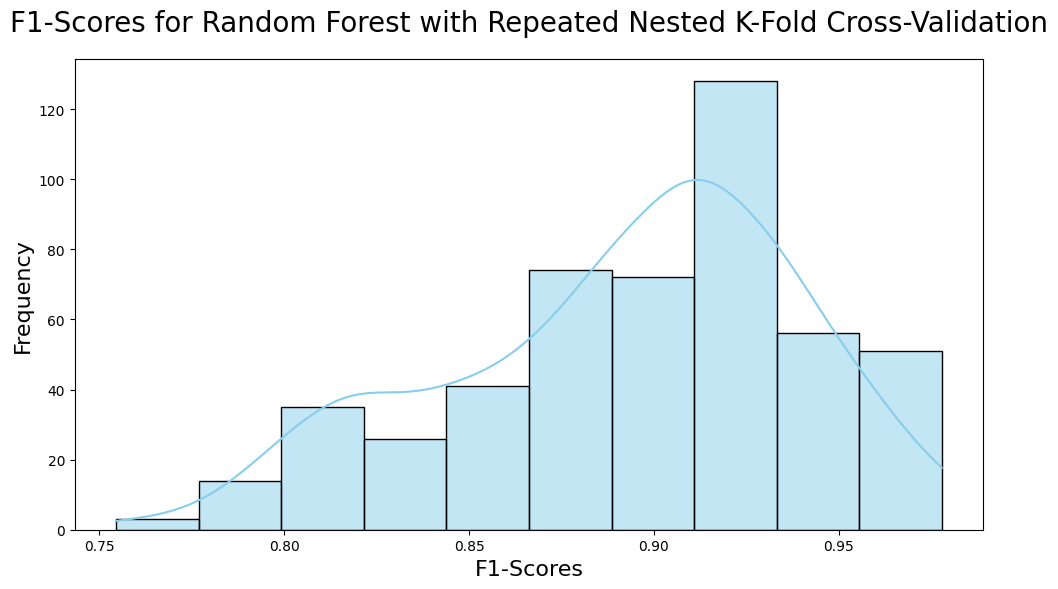

In [12]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(rf_nested_f1_score, bins=10, kde=True, color='skyblue')

# Set the title and labels with larger font
plt.title("F1-Scores for Random Forest with Repeated Nested K-Fold Cross-Validation", fontsize=20, pad=20)
plt.xlabel("F1-Scores", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

# Display the plot with sufficient space for the title
plt.tight_layout()
plt.show()

In [13]:
compute_CI(rf_nested_f1_score)

The 95% Confidence Interval is (0.8873626735610471, 0.8957818478922028)


(0.8873626735610471, 0.8957818478922028)

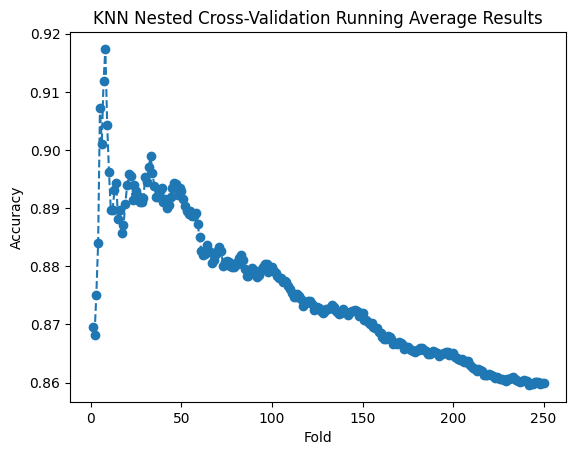

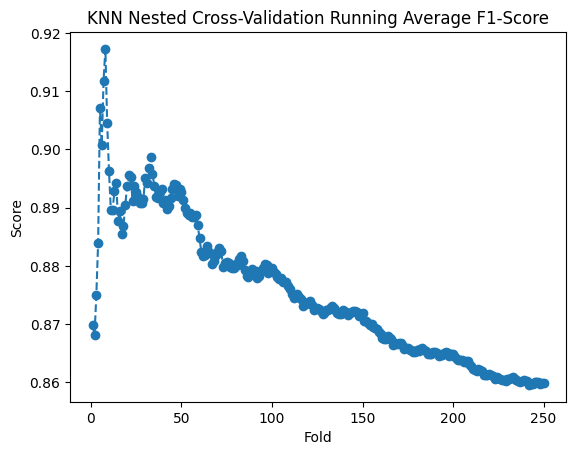

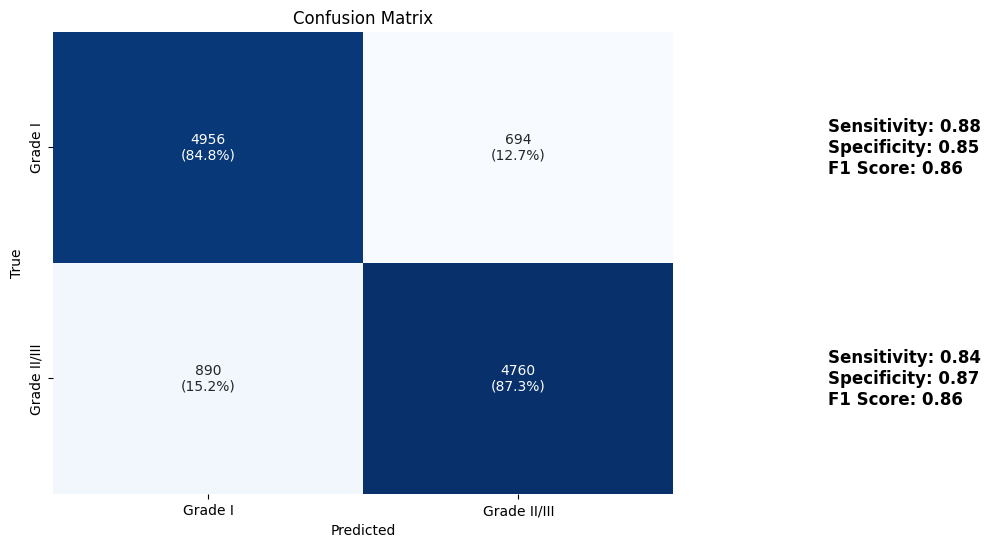

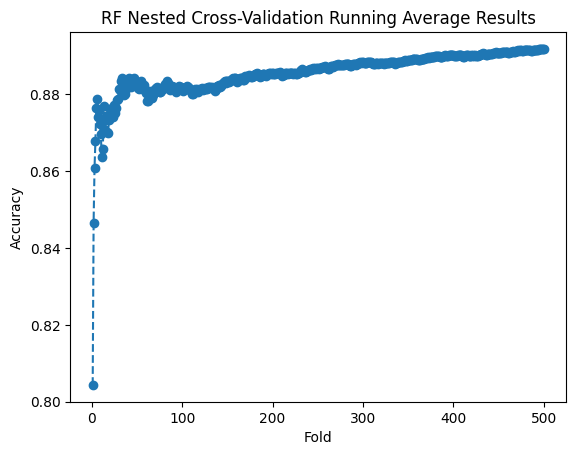

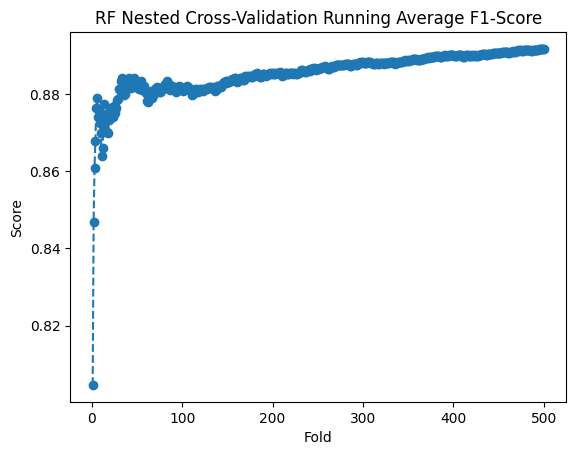

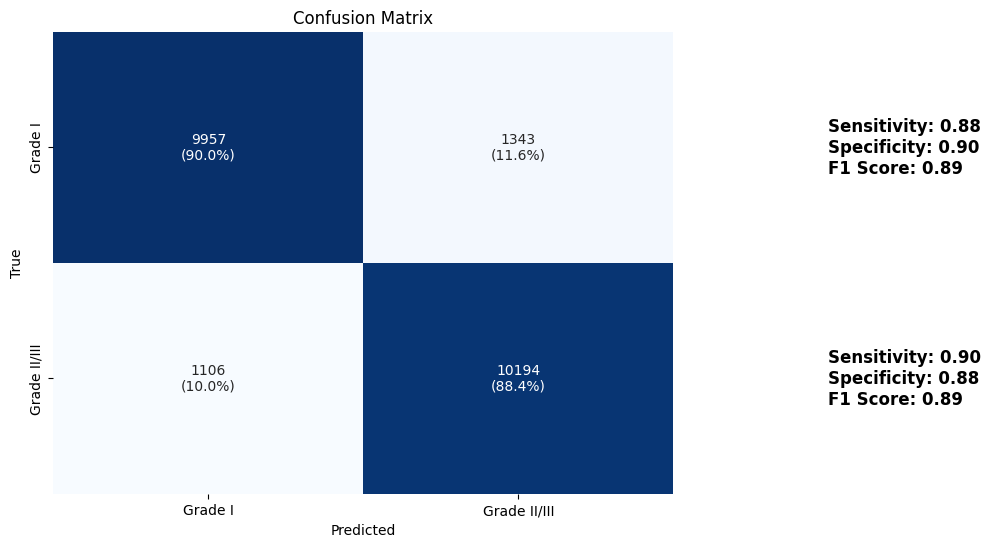

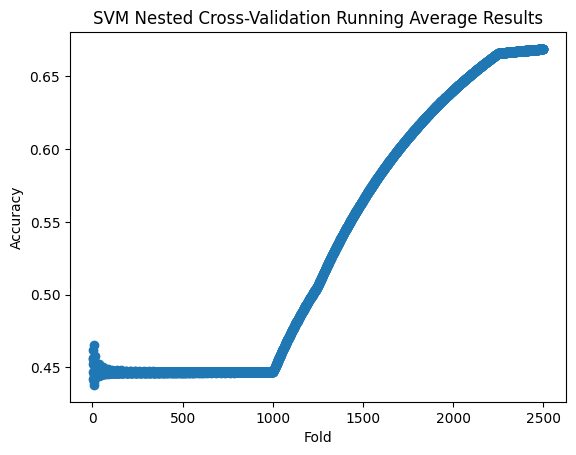

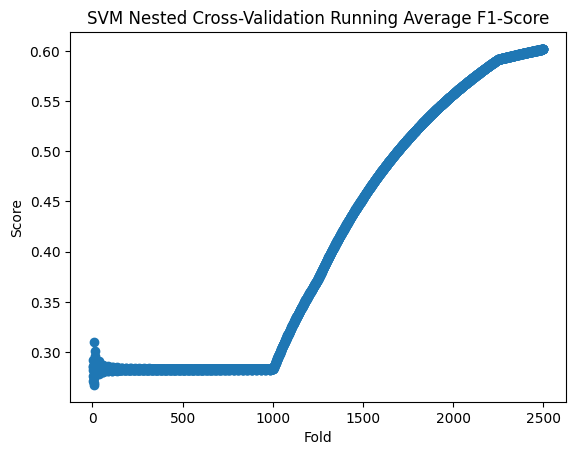

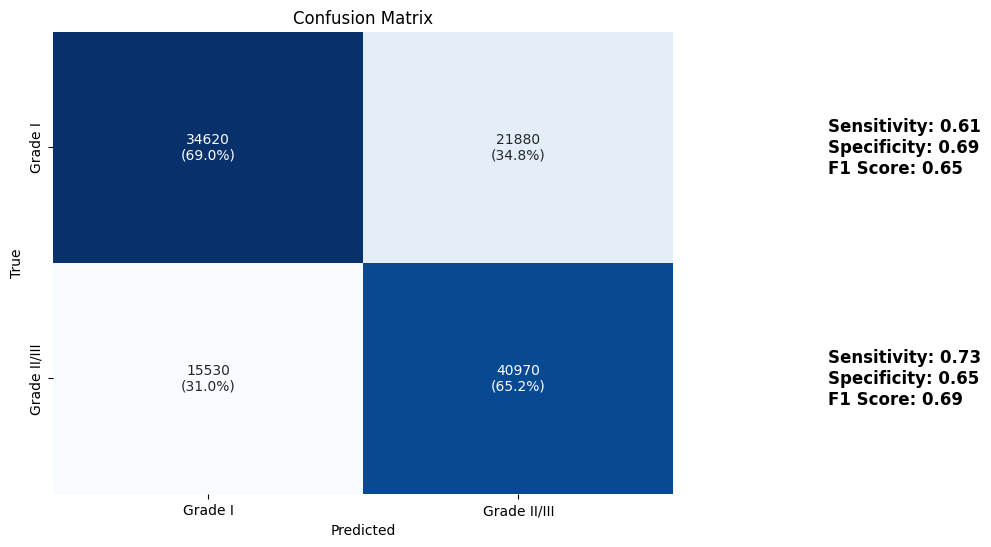

In [14]:
knn_cv_scores = [sum(knn_nested_cv_scores[:i+1]) / (i+1) for i in range(len(knn_nested_cv_scores))]
rf_cv_scores = [sum(rf_nested_cv_scores[:i+1]) / (i+1) for i in range(len(rf_nested_cv_scores))]
svm_cv_scores = [sum(svm_nested_cv_scores[:i+1]) / (i+1) for i in range(len(svm_nested_cv_scores))]

plt.plot(range(1, len(knn_cv_scores) + 1), knn_cv_scores, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('KNN Nested Cross-Validation Running Average Results')
plt.show()
knn_f1_score = [sum(knn_nested_f1_score[:i+1]) / (i+1) for i in range(len(knn_nested_f1_score))]
plt.plot(range(1, len(knn_f1_score) + 1), knn_f1_score, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('KNN Nested Cross-Validation Running Average F1-Score')
plt.show()
plot_confusion_matrix(sum(knn_nested_conf_matrix),class_labels)

plt.plot(range(1, len(rf_cv_scores) + 1), rf_cv_scores, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('RF Nested Cross-Validation Running Average Results')
plt.show()
rf_f1_score = [sum(rf_nested_f1_score[:i+1]) / (i+1) for i in range(len(rf_nested_f1_score))]
plt.plot(range(1, len(rf_f1_score) + 1), rf_f1_score, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('RF Nested Cross-Validation Running Average F1-Score')
plt.show()
plot_confusion_matrix(sum(rf_nested_conf_matrix),class_labels)

plt.plot(range(1, len(svm_cv_scores) + 1), svm_cv_scores, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('SVM Nested Cross-Validation Running Average Results')
plt.show()
svm_f1_score = [sum(svm_nested_f1_score[:i+1]) / (i+1) for i in range(len(svm_nested_f1_score))]
plt.plot(range(1, len(svm_f1_score) + 1), svm_f1_score, marker='o', linestyle='--')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('SVM Nested Cross-Validation Running Average F1-Score')
plt.show()
plot_confusion_matrix(sum(svm_nested_conf_matrix),class_labels)


In [15]:
rf_f1_score[:20]

[0.8046264006108004,
 0.8468126230334226,
 0.8609117872192656,
 0.8677617624923714,
 0.876449199190208,
 0.8788992633587949,
 0.8740871029381865,
 0.8759792232827449,
 0.8725458697297128,
 0.8698286424160525,
 0.863867431209951,
 0.8660922096855979,
 0.8712855245879845,
 0.8773048125142395,
 0.8737695834944605,
 0.87485587012581,
 0.8700773139227063,
 0.8699097922372039,
 0.8732582902854675,
 0.8762100943859128]

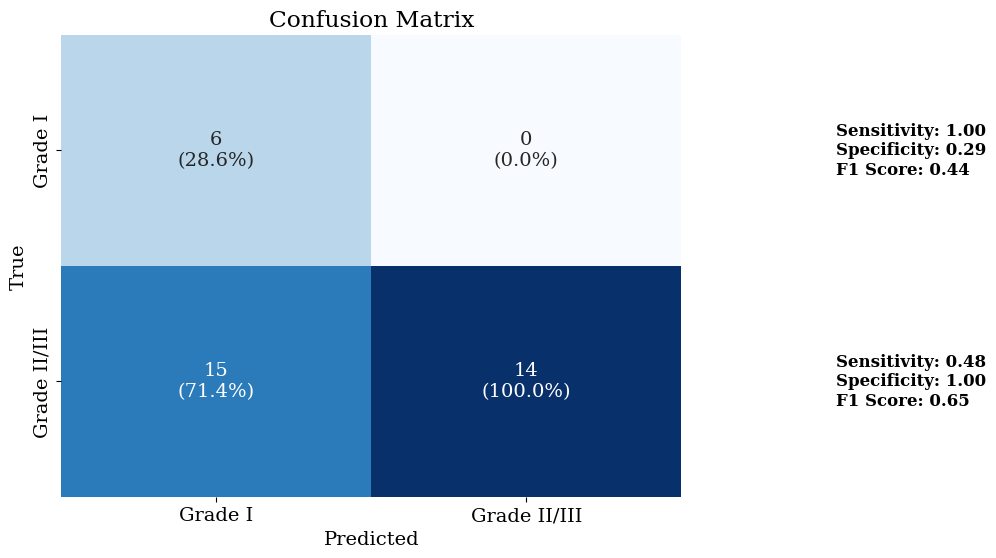

Control Model Confusion Matrix:
[[ 6  0]
 [15 14]]
Control Model Accuracy: 0.5714
Control Model Sensitivity: [1.         0.48275862]
Control Model Specificity: [0.28571429 1.        ]
Control Model F1 Score: 0.6157



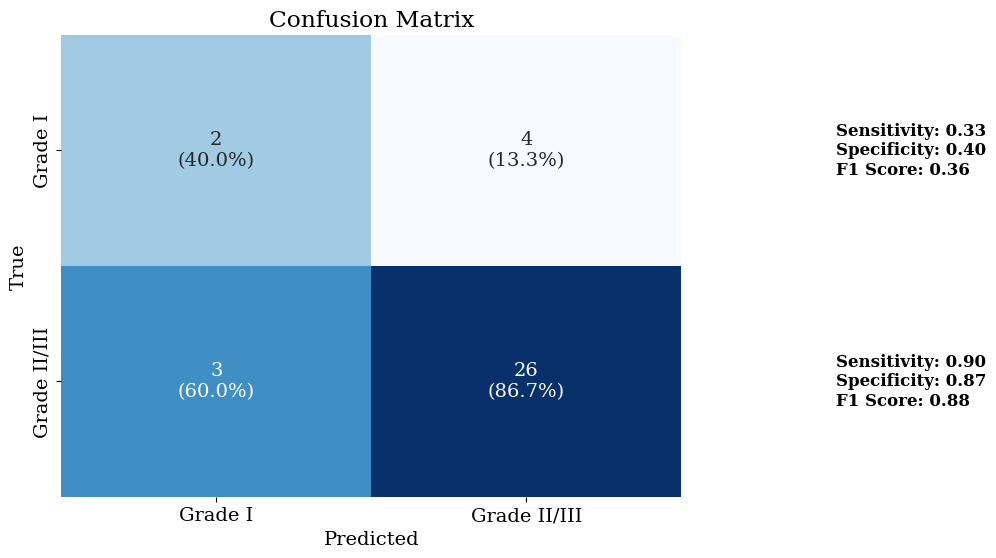

KNN Confusion Matrix:
[[ 2  4]
 [ 3 26]]
KNN Accuracy: 0.8000
KNN Sensitivity: [0.33333333 0.89655172]
KNN Specificity: [0.4        0.86666667]
KNN F1 Score: 0.7926



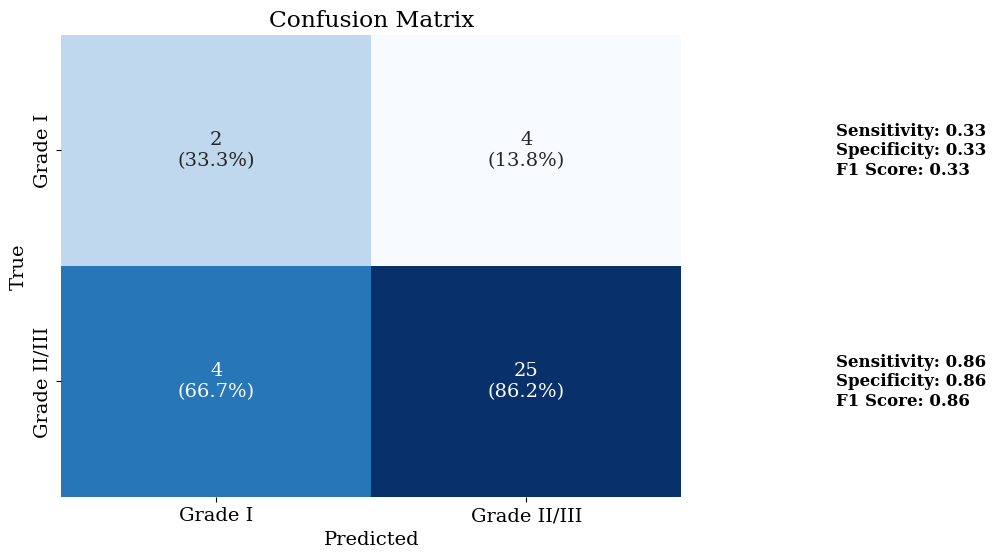

Random Forest Confusion Matrix:
[[ 2  4]
 [ 4 25]]
Random Forest Accuracy: 0.7714
Random Forest Sensitivity: [0.33333333 0.86206897]
Random Forest Specificity: [0.33333333 0.86206897]
Random Forest F1 Score: 0.7714



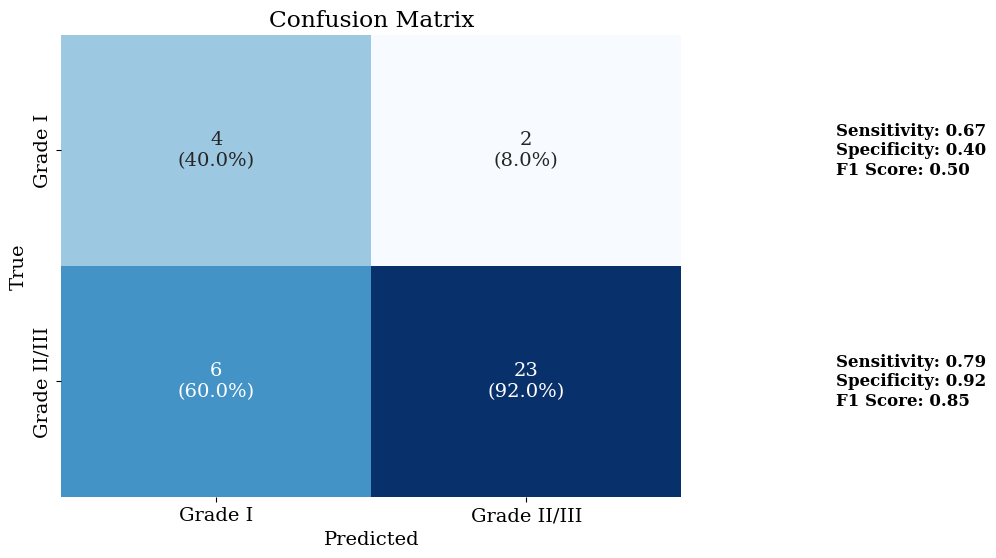

SVM Confusion Matrix:
[[ 4  2]
 [ 6 23]]
SVM Accuracy: 0.7714
SVM Sensitivity: [0.66666667 0.79310345]
SVM Specificity: [0.4  0.92]
SVM F1 Score: 0.7915



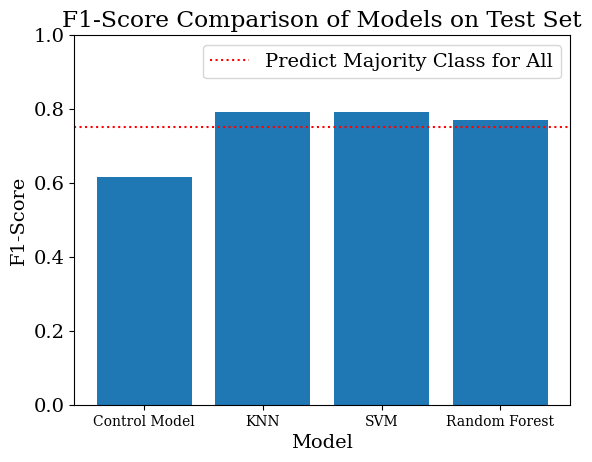

In [23]:
# Train the control model and compare results to other models

# Find the single most important feature
# Here, we'll use the absolute correlation between each feature and the target variable as the measure of importance
feature_importance = np.abs(np.corrcoef(X_train.T, y_train)[0, 1:])
most_important_feature_index = np.argmax(feature_importance)
y_pred = np.zeros(len(X_test))

# Train the control model
# The model will simply predict the class based on the value of the most important feature
if two_class:
    threshold = np.median(X_train[:, most_important_feature_index])
    y_pred[X_test[:, most_important_feature_index] > threshold] = 0
    y_pred[X_test[:, most_important_feature_index] <= threshold] = 1

if three_class:
    # Find the thresholds for separating the three classes
    threshold1 = np.percentile(X_train[:, most_important_feature_index], 33)
    threshold2 = np.percentile(X_train[:, most_important_feature_index], 67)
    y_pred[X_test[:, most_important_feature_index] <= threshold1] = 0
    y_pred[(X_test[:, most_important_feature_index] > threshold1) & (X_test[:, most_important_feature_index] <= threshold2)] = 1
    y_pred[X_test[:, most_important_feature_index] > threshold2] = 2

y_pred_majority = np.ones(len(X_test))
f1_majority = f1_score(y_test, y_pred_majority, average='weighted')
    
models = {
    'Control Model': y_pred,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'SVM': svm_model
}

f1_scores = []

for model_name, model in models.items():
    if model_name == 'Control Model':
        y_pred = model
    else:
        y_pred = model.predict(X_test)
        
    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(np.array(conf_matrix),class_labels)

    # Calculate Sensitivity and Specificity
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Confusion Matrix:\n{conf_matrix}")
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Sensitivity: {sensitivity}")
    print(f"{model_name} Specificity: {specificity}")
    print(f"{model_name} F1 Score: {f1:.4f}\n")

    f1_scores.append((model_name, f1))

# Sort models by F1 score
f1_scores.sort(key=lambda x: x[1], reverse=True)

# Move the control model to the left
control_model = f1_scores.pop()
f1_scores.insert(0, control_model)

# Create bar plot
labels, scores = zip(*f1_scores)
plt.bar(labels, scores)
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison of Models on Test Set')
plt.xticks(fontsize=10)
plt.axhline(y=f1_majority, color='red', linestyle='dotted', label='Predict Majority Class for All')
plt.legend()
plt.ylim([0,1])
plt.show()


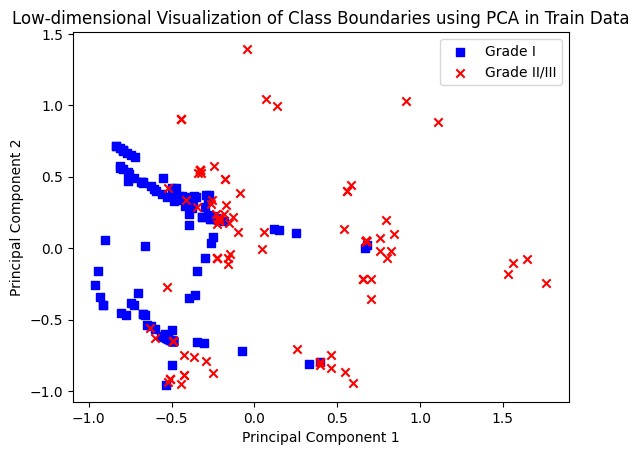

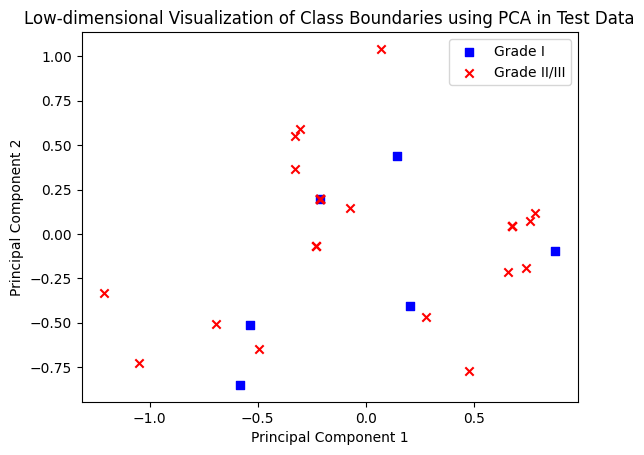

In [17]:
# Visualize class boundaries using PCA
if use_PCA:
    colors = ['blue', 'red', 'green']
    markers = ['s', 'x', 'o']
    for l, c, m in zip(np.unique(y_train), colors, markers):
        if three_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II'
            else:
                grade = 'Grade III'
        elif two_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II/III'
        plt.scatter(X_train[y_train == l, 0], X_train[y_train == l, 1], c=c, label=grade, marker=m)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Train Data')
    plt.show()

    colors = ['blue', 'red', 'green']
    markers = ['s', 'x', 'o']
    for l, c, m in zip(np.unique(y_test), colors, markers):
        if three_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II'
            else:
                grade = 'Grade III'
        elif two_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II/III'
        plt.scatter(X_test[y_test == l, 0], X_test[y_test == l, 1], c=c, label=grade, marker=m)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Test Data')
    plt.show()


In [18]:
from matplotlib.lines import Line2D

if use_PCA and number_of_PCA_components == 2:
    models = {
        'KNN': knn_model,
        'Random Forest': rf_model,
        'SVM': svm_model,
        'Logistic Regression': lr_model
    }

    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Create a 3x1 grid of subplots
    fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
    axarr = axarr.flatten()
    
    colors = np.array(['blue', 'red'])
    markers = np.array(['s', 'x'])

    for idx, (name, model) in enumerate(models.items()):
        if name == 'Logistic Regression':
            y_logit = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).detach().numpy()
            y_prob = 1 / (1 + np.exp(-y_logit))
            y_pred = np.where(y_prob[:, 0] > 0.5, 1, 0)
            Z = y_pred.reshape(xx.shape)
        else:
            # Fit the model and predict on the mesh grid
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

        # Plot the decision boundaries
        axarr[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        for i in range(len(X_test.tolist())):
            axarr[idx].scatter(X_test[i, 0], X_test[i, 1], c=colors[y_test.astype(int)][i], marker=markers[y_test.astype(int)][i])
        axarr[idx].set_xlabel('Feature 1')
        axarr[idx].set_ylabel('Feature 2')
        axarr[idx].set_title(name)

    # Add the legend
    legend_elements = [Line2D([0], [0], marker='s', color='w', label='Grade I', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='x', color='w', label='Grade II/III', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()


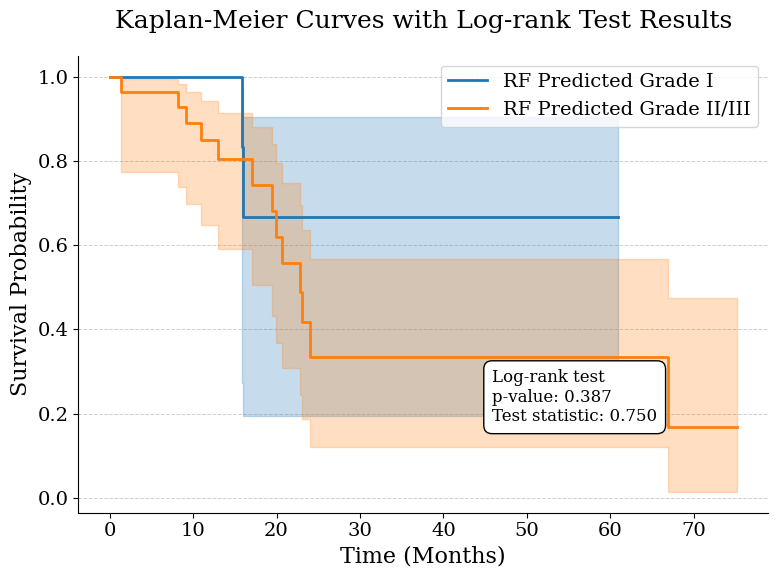

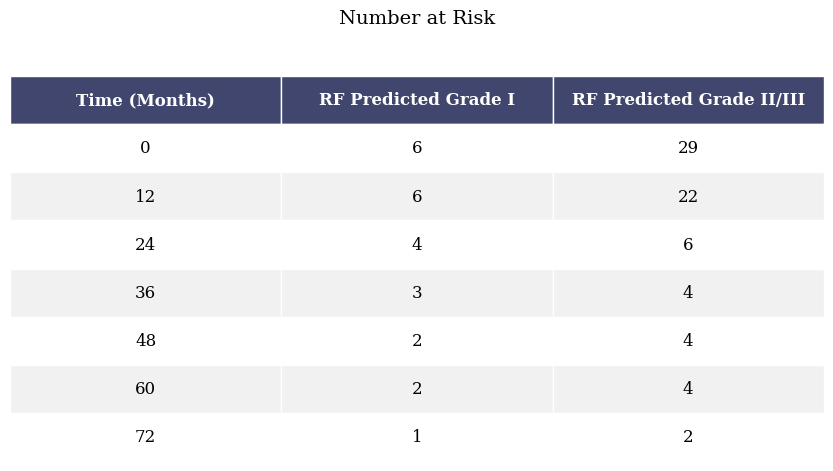

In [19]:
# Add Progression Free Survival and Overall Survival Curves

# Get the patient IDs in the test set
# Find the corresponding PFS and OS for each of the patients in the test set (make a new variables y_pfs and y_os to track this)
# Plot the Kaplan Meier curves for predicted Grade I vs predicted Grade II/III

df_y_survival = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

# Get the Overall Survival (Months) for the patients in X_test
y_time_os = df_y_survival.loc[(patient_ids_test, slice(None)), "Overall Survival (Months)"].reset_index(level=1, drop=True)
y_status_os = df_y_survival.loc[(patient_ids_test, slice(None)), "Overall Survival Status"].reset_index(level=1, drop=True)
y_time_pfs = df_y_survival.loc[(patient_ids_test, slice(None)), "Progress Free Survival (Months)"].reset_index(level=1, drop=True)
y_status_pfs = df_y_survival.loc[(patient_ids_test, slice(None)), "Progression Free Status"].reset_index(level=1, drop=True)

# Set survival status and progression free status to 0 or 1 and convert times from strings to floats
y_time_os = y_time_os.astype(float)
y_status_os = y_status_os.replace({"0:LIVING": 0, "1:DECEASED": 1})
y_time_pfs = y_time_pfs.astype(float)
y_status_pfs = y_status_pfs.replace({"0:CENSORED": 0, "1:PROGRESSION": 1})

y_pred = rf_model.predict(X_test)


# Sample data
data = {'time': y_time_os,
        'event': y_status_os,
        'group': y_pred}

df = pd.DataFrame(data)

# Fit Kaplan-Meier curves for each group
kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter()

group_A = df[df['group'] == 0]
group_B = df[df['group'] == 1]

kmf_A.fit(group_A['time'], group_A['event'], label='RF Predicted Grade I')
kmf_B.fit(group_B['time'], group_B['event'], label='RF Predicted Grade II/III')

# Perform log-rank test
results = logrank_test(group_A['time'], group_B['time'], event_observed_A=group_A['event'], event_observed_B=group_B['event'])
log_rank_p_value = results.p_value
test_statistic = results.test_statistic

# Set font style
font = {'family': 'serif',
        'weight': 'normal',
        'size': 14}

plt.rc('font', **font)

# Create plot with better formatting and styling
fig, ax = plt.subplots(figsize=(8, 6))
kmf_A.plot(ax=ax, linewidth=2)
kmf_B.plot(ax=ax, linewidth=2)

# Add log-rank test results and other metrics to the plot
ax.annotate(f'Log-rank test\np-value: {log_rank_p_value:.3f}\nTest statistic: {test_statistic:.3f}', 
            xy=(0.6, 0.2), xycoords='axes fraction', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

ax.set_xlabel('Time (Months)', fontsize=16)
ax.set_ylabel('Survival Probability', fontsize=16)
ax.set_title('Kaplan-Meier Curves with Log-rank Test Results', fontsize=18, pad=20)
ax.legend(fontsize=14)

# Customize the grid
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_axisbelow(True)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Define time points for the number at risk table
time_points = np.arange(0, df['time'].max(), 12)  # Every 12 months

# Calculate the number at risk for each group at the defined time points
number_at_risk_A = kmf_A.event_table.reindex(time_points, method='ffill')['at_risk'].values
number_at_risk_B = kmf_B.event_table.reindex(time_points, method='ffill')['at_risk'].values

# Create the table with the number at risk for each group at the defined time points
at_risk_table = pd.DataFrame({'Time (Months)': time_points,
                              'RF Predicted Grade I': number_at_risk_A,
                              'RF Predicted Grade II/III': number_at_risk_B})

# Create a function to format the table
def render_mpl_table(data, col_width=3, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, ax=None, table_title=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            cell.get_text().set(ha='center') # Align header text to center
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
            cell.get_text().set(ha='center')  # Align cell text to center
            value = cell.get_text().get_text()
            if '.' in value:
                try:
                    float_val = float(value)
                    if float_val.is_integer():
                        cell.get_text().set_text(f'{int(float_val)}')
                except ValueError:
                    pass
    
    # Add table title if provided
    if table_title:
        ax.annotate(table_title, xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=font_size + 2, ha='center', va='center')
        
    return ax


# Add the table to the plot
render_mpl_table(at_risk_table.round(1), header_columns=0, col_width=3.5, table_title='Number at Risk')
plt.show()



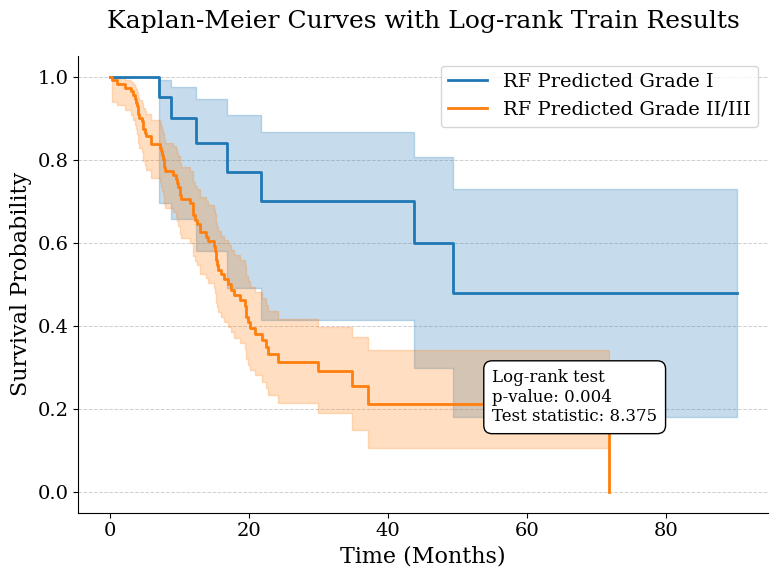

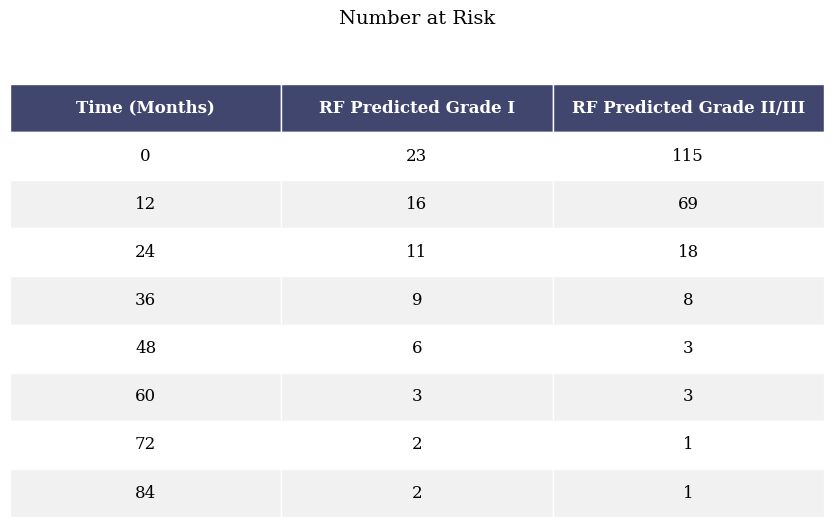

In [20]:
# Add Progression Free Survival and Overall Survival Curves

'''
First, regenerate just train dataset without SMOTE, which may have been used above
SMOTE adds new synthetic data that we don't want to include in our survival curve analysis
'''

'''
Load in the data
'''

X_train=X_train_no_SMOTE
y_train=y_train_no_SMOTE


# Get the patient IDs in the TRAIN SET (this is not a good estimate of the model performance, rather it estimates the predictiveness of grade for survival)
# Find the corresponding PFS and OS for each of the patients in the test set (make a new variables y_pfs and y_os to track this)
# Plot the Kaplan Meier curves for predicted Grade I vs predicted Grade II/III

df_y_survival = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

patient_ids=patient_ids_train
# Get the Overall Survival (Months) for the patients in X_test
y_time_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival (Months)"].reset_index(level=1, drop=True)
y_status_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival Status"].reset_index(level=1, drop=True)
y_time_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progress Free Survival (Months)"].reset_index(level=1, drop=True)
y_status_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progression Free Status"].reset_index(level=1, drop=True)

# Set survival status and progression free status to 0 or 1 and convert times from strings to floats
y_time_os = y_time_os.astype(float)
y_status_os = y_status_os.replace({"0:LIVING": 0, "1:DECEASED": 1})
y_time_pfs = y_time_pfs.astype(float)
y_status_pfs = y_status_pfs.replace({"0:CENSORED": 0, "1:PROGRESSION": 1})

y_train_pred = rf_model.predict(X_train)

# Sample data
data = {'time': y_time_os,
        'event': y_status_os,
        'group': y_train_pred}

df = pd.DataFrame(data)

# Fit Kaplan-Meier curves for each group
kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter()

group_A = df[df['group'] == 0]
group_B = df[df['group'] == 1]

kmf_A.fit(group_A['time'], group_A['event'], label='RF Predicted Grade I')
kmf_B.fit(group_B['time'], group_B['event'], label='RF Predicted Grade II/III')

# Perform log-rank test
results = logrank_test(group_A['time'], group_B['time'], event_observed_A=group_A['event'], event_observed_B=group_B['event'])
log_rank_p_value = results.p_value
test_statistic = results.test_statistic

# Set font style
font = {'family': 'serif',
        'weight': 'normal',
        'size': 14}

plt.rc('font', **font)

# Create plot with better formatting and styling
fig, ax = plt.subplots(figsize=(8, 6))
kmf_A.plot(ax=ax, linewidth=2)
kmf_B.plot(ax=ax, linewidth=2)

# Add log-rank test results and other metrics to the plot
ax.annotate(f'Log-rank test\np-value: {log_rank_p_value:.3f}\nTest statistic: {test_statistic:.3f}', 
            xy=(0.6, 0.2), xycoords='axes fraction', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

ax.set_xlabel('Time (Months)', fontsize=16)
ax.set_ylabel('Survival Probability', fontsize=16)
ax.set_title('Kaplan-Meier Curves with Log-rank Train Results', fontsize=18, pad=20)
ax.legend(fontsize=14)

# Customize the grid
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
ax.set_axisbelow(True)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Define time points for the number at risk table
time_points = np.arange(0, df['time'].max(), 12)  # Every 12 months

# Calculate the number at risk for each group at the defined time points
number_at_risk_A = kmf_A.event_table.reindex(time_points, method='ffill')['at_risk'].values
number_at_risk_B = kmf_B.event_table.reindex(time_points, method='ffill')['at_risk'].values

# Create the table with the number at risk for each group at the defined time points
at_risk_table = pd.DataFrame({'Time (Months)': time_points,
                              'RF Predicted Grade I': number_at_risk_A,
                              'RF Predicted Grade II/III': number_at_risk_B})

# Create a function to format the table
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, ax=None, table_title=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            cell.get_text().set(ha='center') # Align header text to center
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
            cell.get_text().set(ha='center')  # Align cell text to center
            value = cell.get_text().get_text()
            if '.' in value:
                try:
                    float_val = float(value)
                    if float_val.is_integer():
                        cell.get_text().set_text(f'{int(float_val)}')
                except ValueError:
                    pass
    
    # Add table title if provided
    if table_title:
        ax.annotate(table_title, xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=font_size + 2, ha='center', va='center')
        
    return ax


# Add the table to the plot
render_mpl_table(at_risk_table.round(1), header_columns=0, col_width=3.5, table_title='Number at Risk')
plt.show()


